In [2]:
using ApproxBayes
using Distributions

In [1]:
Threads.nthreads()

1

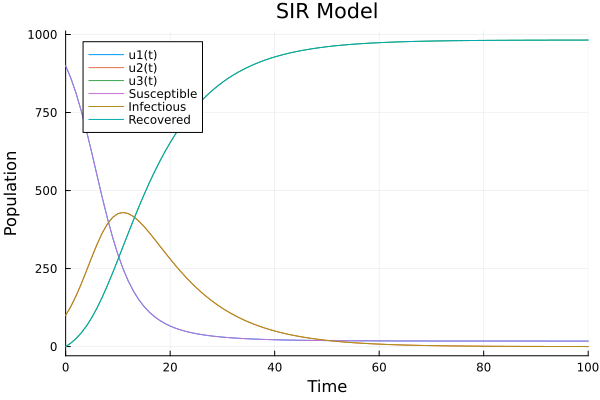

In [3]:
using DifferentialEquations, Plots

function sir_model!(du, u, p, t)
    β, γ = p
    S, I, R = u
    N = S + I + R
    du[1] = -β * S * I / N
    du[2] = β * S * I / N - γ * I
    du[3] = γ * I
end

function simulate_sir_model(S0, I0, R0, β, γ, tspan)
    u0 = [S0, I0, R0]
    p = [β, γ]
    # ODE
    prob = ODEProblem(sir_model!, u0, tspan, p)
    sol = solve(prob, Tsit5(),  saveat = 1)
    
    # Stochastic
    #prob = SDEProblem(sir_model!, u0, p , (0.0, 1.0))
    #dt = 1
    #sol = solve(prob, EM(), dt=dt)
    return sol
end

# Example usage
S0 = 900
I0 = 100
R0 = 0
β = 0.4
γ = 0.1
tspan = (0.0, 100.0)

sol = simulate_sir_model(S0, I0, R0, β, γ, tspan)

plot(sol, title="SIR Model", xlabel="Time", ylabel="Population")
plot!(sol.t, sol[1, :], label="Susceptible")
plot!(sol.t, sol[2, :], label="Infectious")
plot!(sol.t, sol[3, :], label="Recovered")


# Stochastic simulation

In [4]:
using Distributions
using ProtoStructs
using Parameters
rand_binom(n,p) = rand(Binomial(n,p))

rand_binom (generic function with 1 method)

In [5]:
1.6 * 0.19

0.30400000000000005

In [6]:
# ### Simple SIR model 

# +
days = 365
@proto struct SimpleParams
    γ::Float64 = 0.19
    days::Int64 = days
    N0::Int64 = 1000
    β::Float64 = 1.6*γ
end

@proto struct SimpleSIRModel
    S::Vector{Int64} = fill(-1000, days)
    I::Vector{Int64} = fill(-1000, days)
    R::Vector{Int64} = fill(-1000, days)
end

function set_values(model::SimpleSIRModel, ind::Int64, S, I, R)
    model.S[ind] = S
    model.I[ind] = I
    model.R[ind] = R
    return Nothing
end

function get_values(model::SimpleSIRModel, ind::Int64)
    return model.S[ind], model.I[ind], model.R[ind]
end

function create_init(p::SimpleParams, I0)
   return I0
end

function run_sim(p::SimpleParams, m::SimpleSIRModel, days, I0)
    @unpack N0, β, γ = p
    I0 = create_init(p, I0)
    set_values(m, 1, p.N0 - I0, I0, 0)
    
    for t in 2:days
        S, I, R = get_values(m, t-1)
        
        new_inf = rand_binom(S, β*I/N0)
        rec_I = rand_binom(I, γ)
        newS = S - new_inf
        newI = I + new_inf - rec_I
        newR = R           + rec_I
        set_values(m, t, newS, newI, newR)
    end
    return m
end



run_sim (generic function with 1 method)

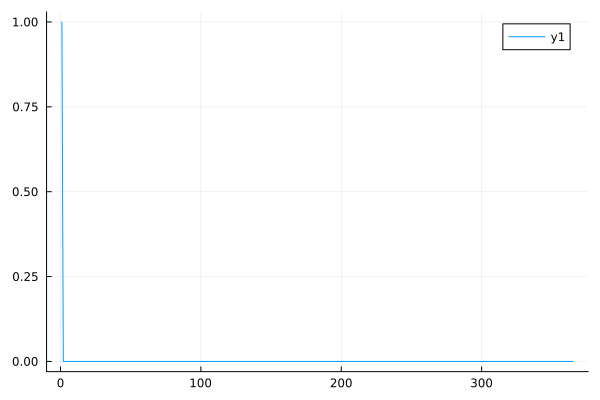

In [7]:
p = SimpleParams()
m = SimpleSIRModel()
res = run_sim(p, m, days, 1)
plot(1:days, res.I)

### Estimate parameter using Approximate Bayesian Computations 

0.30400000000000005


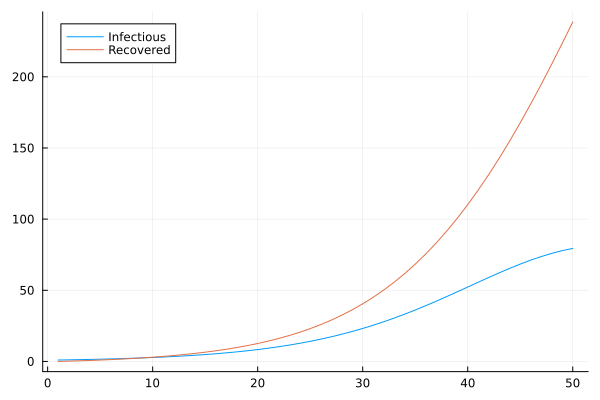

In [194]:
# Example usage
S0 = 999
I0 = 1
R0 = 0
Repro = 1.6
γ = 0.19
β = Repro * γ
println(β)
days = 50
tspan = (1.0, days)

sol = simulate_sir_model(S0, I0, R0, β, γ, tspan)

I_obs = sol[2,:]
#plot(sol.t, sol[1, :], label="Susceptible", title="SIR model")
plot(sol.t, sol[2, :], label="Infectious")
plot!(sol.t, sol[3, :], label="Recovered")

In [195]:
using Random
Random.seed!(1)

TaskLocalRNG()

In [196]:
p = SimpleParams(days=days)
m = SimpleSIRModel()
res = run_sim(p, m, days, 1)
#plot(1:days, res.I)

SimpleSIRModel{NamedTuple{(:S, :I, :R), Tuple{Vector{Int64}, Vector{Int64}, Vector{Int64}}}}((S = [999, 998, 998, 998, 998, 998, 996, 994, 993, 991  …  761, 748, 739, 727, 720, 705, 694, 680, 671, 664], I = [1, 2, 2, 2, 1, 1, 3, 4, 5, 7  …  57, 57, 58, 59, 58, 63, 61, 61, 61, 54], R = [0, 0, 0, 0, 1, 1, 1, 2, 2, 2  …  182, 195, 203, 214, 222, 232, 245, 259, 268, 282]))

In [198]:
function distance_SIR(params, constants, targetdata)
    p = SimpleParams(days=constants[1], β=params[1], N0=5000)
    m = SimpleSIRModel()
    res = run_sim(p, m, days, 1)
    err = res.I .- I_obs .|> abs |> sum
    return err, 1
end

distance_SIR (generic function with 1 method)

In [199]:
setup = ABCSMC(distance_SIR,
    1,
    0.1 |> Float64,
    Prior([Uniform(0.0, 1.0)]);
    maxiterations = 10^6,
    constants=[days],
    convergence=0.04,
    nparticles=1000,
)

ABCSMC(distance_SIR, 1, 10000.0, 0.1, 1000, Any[50], 1000000, Prior((Uniform{Float64}(a=0.0, b=1.0),)), 0.3, 0.04, Kernel(ApproxBayes.perturbation_function, ApproxBayes.pdf_function, ApproxBayes.calculate_kernel_parameters, [0.13447863908787844]))

In [200]:
# run ABC inference
Random.seed!(2)
rejection = Nothing
@time rejection = runabc(setup, I_obs, verbose=true, progress=true, parallel=false)

##################################################
Use ABC rejection to get first population
Preparing to run in serial on 1 processor
Running ABC SMC... 

Preparing to run in serial on 1 processor
##################################################
Total number of simulations: 7.29e+03
Cumulative number of simulations = [1904, 7294]
Acceptance ratio: 1.37e-01
Tolerance schedule = [1289.76, 1230.14]

Median (95% intervals):
Parameter 1: 0.20 (0.02,0.48)
##################################################

##################################################
Total number of simulations: 2.18e+04
Cumulative number of simulations = [1904, 7294, 21818]
Acceptance ratio: 4.58e-02
Tolerance schedule = [1289.76, 1230.14, 661.54]

Median (95% intervals):
Parameter 1: 0.26 (0.13,0.36)
##################################################

##################################################
Total number of simulations: 5.64e+04
Cumulative number of simulations = [1904, 7294, 21818, 56447]
Acceptance rat

ABC SMC population 5, new ϵ: 244.91... 100%|██████████████████████████████| Time: 0:00:01


##################################################
Total number of simulations: 2.64e+05
Cumulative number of simulations = [1904, 7294, 21818, 56447, 128001, 263838]
Acceptance ratio: 3.79e-03
Tolerance schedule = [1289.76, 1230.14, 661.54, 357.28, 244.91, 182.09]

Median (95% intervals):
Parameter 1: 0.27 (0.23,0.32)
##################################################



ABC SMC population 6, new ϵ: 182.09... 100%|██████████████████████████████| Time: 0:00:03


##################################################
Total number of simulations: 6.88e+05
Cumulative number of simulations = [1904, 7294, 21818, 56447, 128001, 263838, 687747]
Acceptance ratio: 1.45e-03
Tolerance schedule = [1289.76, 1230.14, 661.54, 357.28, 244.91, 182.09, 147.33]

Median (95% intervals):
Parameter 1: 0.27 (0.23,0.31)
##################################################



ABC SMC population 7, new ϵ: 147.33... 100%|██████████████████████████████| Time: 0:00:09


##################################################
Total number of simulations: 2.02e+06
Cumulative number of simulations = [1904, 7294, 21818, 56447, 128001, 263838, 687747, 2017280]
Acceptance ratio: 4.96e-04
Tolerance schedule = [1289.76, 1230.14, 661.54, 357.28, 244.91, 182.09, 147.33, 124.76]

Median (95% intervals):
Parameter 1: 0.27 (0.23,0.30)
##################################################


Passed maxiterations=1000000, stop ABC SMC

 15.843704 seconds (116.83 M allocations: 6.276 GiB, 6.62% gc time, 0.09% compilation time)


Total number of simulations: 2.02e+06
Cumulative number of simulations = [1904, 7294, 21818, 56447, 128001, 263838, 687747, 2017280]
Acceptance ratio: 4.96e-04
Tolerance schedule = [1289.76, 1230.14, 661.54, 357.28, 244.91, 182.09, 147.33, 124.76]

Median (95% intervals):
Parameter 1: 0.27 (0.23,0.30)


In [201]:
rejection

Total number of simulations: 2.02e+06
Cumulative number of simulations = [1904, 7294, 21818, 56447, 128001, 263838, 687747, 2017280]
Acceptance ratio: 4.96e-04
Tolerance schedule = [1289.76, 1230.14, 661.54, 357.28, 244.91, 182.09, 147.33, 124.76]

Median (95% intervals):
Parameter 1: 0.27 (0.23,0.30)


In [202]:
length(rejection.parameters)

1000

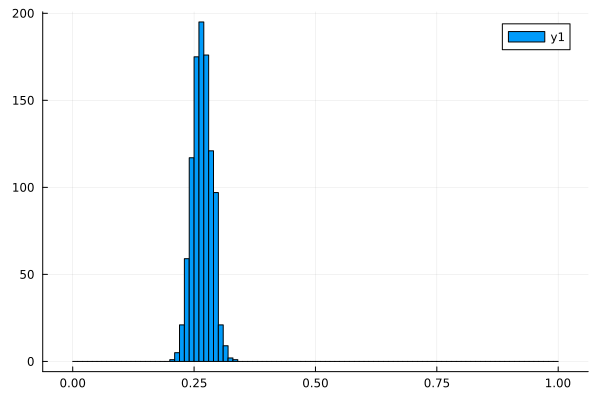

In [203]:
histogram(rejection.parameters, bins=0:0.01:1)

In [225]:
β = rejection.parameters[:,1] |> median 
println(β)
β/γ

0.26586602468186493


1.3992948667466576

## Estimated with different population size

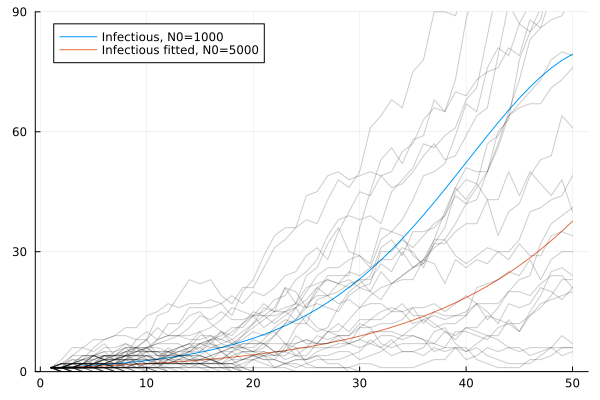

"tmp.png"

In [221]:
# Example usage
S0 = 999
I0 = 1
R0 = 0
Repro = 1.6
γ = 0.19
β = Repro * γ
#println(β)
tspan = (1.0, days)

sol = simulate_sir_model(S0, I0, R0, β, γ, tspan)
#plot(sol.t, sol[1, :], label="Susceptible", title="SIR model")
pl = plot(sol.t, sol[2, :], label="Infectious, N0=1000")
#plot!(sol.t, sol[3, :], label="Recovered")
S0 = 5000
β = rejection.parameters[:,1] |> median  
sol = simulate_sir_model(S0, I0, R0, β, γ, tspan)
plot!(sol.t, sol[2, :], label="Infectious fitted, N0=5000")
for i in 1:100
    p = SimpleParams(days=days, β=β, N0=5000)
    m = SimpleSIRModel()
    res = run_sim(p, m, days, 1)
    plot!(sol.t, res.I, color="black", alpha=0.2, label="", ylim=(0,90))
end
display(pl)
png(pl, "tmp.png")